# Assignment 1
**Samuel Sheehy (Student ID 18143565)**

**Techniques of High Performance Computing (PHAS0102)**

**MSc Scientific Computing, University College London**, **2019-2020**

## Setup Notebook
Import libraries that will be used for the completion of both questions.

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from time import clock

## Question 1: Random Walk on a Lattice
The objective is to estimate the probability function of a particle reaching the bottom edge of a lattice as it moves randomly over the lattice. In a fist instance, I implemented a version of the code with no concern for speed, which I then optimised for performance. Only the optimised version is presented here.

The following conventions are set explicitly for reference during the implementation:
* 0 is North, 1 is East, 2 is South, 3 is West
* Moving North decreases position, moving East increases position
* Longitudinal movement is index 0, Latteral movement is index 1
* A run will only finish when a particle reaches an edge
* A run is considered a success when the particle has reached the bottom edge. Otherwise it is considered a failure.

The approach to optimising the code was to consider methods that would both increase execution speed and reduce down time on any of the processors. Thus, instead of performing a run consisting of a sinlge particle placed on the lattice, in a run each lattice point is initialised with particle and a set of random movements is applied to all the particles simultaneously. This allows the algorithm to make use of efficient implementations of vector addition. As the particles progress in their random walks, when one reaches an edge, it is removed from the next round of step execution. This ensures that points to do keep moving once they have reached an edge and that the code is not performing additions on particles that cannot move anyway.

The code is implemented using ```numba```'s JIT compiler. This tool allows the code to run fast and it makes available Numba's parallel processing feature. The ```numexpr``` library was considered for this implementation, but while Numexpr has multicore abilities when Intel's MLK libraries are installed, this is not guaranteed to be the case on every machine. Because ```numexpr``` is nor compatible with ```numba```, this meant that it could not be used in this implementation. Python's ```multiprocessing``` library was also considered; however, considering the simplicity of this program, the overhead for using these features was too high, especially when numba'a automatic parallelisation feature is available.

First the code is presented followed by an analysis of lattice's convergence.

### Perfomance-Optimised Code

In [119]:
#                                                                 #
#     Performance-Optimised Implementation of a Random Walk       # 
#                                                                 #
#                                                                 #

@njit(['float64[:,:](int64)'])
def initialise_starting_points(size):
    """
    Create a set of vectors representing every point
    on the lattice. These are generated all at once so that
    the program can apply steps to each particle in one
    vector addition. This is faster than following only one
    particle at a time.
    """
    number_of_points = size**2
    indexes = np.arange(number_of_points)
    starting_points = np.empty((number_of_points, 2))
    starting_points[:, 0] = indexes%size # Generates column indexes
    starting_points[:, 1] = indexes//size # Generates row indexes
    return starting_points


@njit(['float64[:,:](int64)'])
def generate_random_steps(number_of_points):
    """
    Generate a set of random steps. Numba did not seem
    to support an integer being used to select entries
    from a smaller matrix, so to enable vector-wise generation
    of random steps, this function implements trigonometric functions.
    """
    steps = np.zeros((number_of_points, 2))
    output = np.empty_like(steps)
    directions = np.random.randint(0, 4, (number_of_points))
    steps[:, 0] = np.cos(directions/4*2*np.pi)
    steps[:, 1] = np.sin(directions/4*2*np.pi)
    np.round(steps, 1, output)
    return output
    

@njit(['float64[:,:](float64[:,:], float64[:,:])'])
def step(particles, steps):
    """
    Peform a step on the given particles, returning their new
    position.
    """
    return particles+steps
    
    

@njit(['float64[:,:](float64[:,:])'])
def step_randomly(particles):
    """
    Perform a step in a random direction for each respective
    point provided to the function.
    """
    number_of_points = len(particles)
    steps = generate_random_steps(number_of_points)
    return step(particles, steps)


@njit(['float64[:](float64[:,:], int64)'])
def get_states(particles, size):
    """
    Determine the state of each particle provided: is it on the lower
    border, a different border, or on none.
    """
    states = np.zeros((size**2, 1))
    actual_width = particles[:, 0]
    actual_height = particles[:, 1]
    on_south = actual_height >= (size-1)
    on_north = actual_height <= 0
    on_east = actual_width >= (size-1) 
    on_west = actual_width <= 0 
    states[on_north | on_east | on_west] = 1
    states[on_south] = 2
    return states.flatten() # Return a 1-D array


@njit(['float64[:,:](float64[:,:], int64)'])
def random_walk(particles, size):
    """
    Perform a run on every point in the lattice, by repeatidly stepping
    the points in random directions. Once a particle has reached
    a "finished" state (i.e. it has reached a border), it is filtered
    out from performing new steps to avoid pointless calculations and
    gain some computational efficiency.
    """
    states = get_states(particles, size)
    while particles[states == 0].size > 0:
        particles[states == 0] = step_randomly(particles[states == 0])
        states = get_states(particles, size)
    return particles


@njit(['float64[:](float64[:,:], int64)'])
def get_success(particles, size):
    """
    Determine if the particle has succeeded in reaching the bottom
    edge. 
    """
    states = get_states(particles, size)
    successes = states >= 2 # In the final addition of all the states
                            # the bottom-left and bottom-right corners
                            # come to 3, so the greater-than symbold 
                            # ensures they are included in the success
                            # scale
    return successes*1.0 # Converts from integer to float


@njit(['float64[:,:](int64, int64)'], parallel=True)
def measure_success(iterations, size):
    """
    Perform the measurement of the success rate on all points
    of the lattice for the given number of iterations. This
    implements ```numba```'s automatic parallelisation feature,
    so that multiple experiments can run concurrently.
    """
    # Initialise results container
    results = np.zeros((size**2,), dtype=np.double)
    # Parallel-section
    for _ in prange(iterations):
        # Setup
        particles = initialise_starting_points(size)
        # Run Measurment
        particles = random_walk(particles, size)
        # Save results
        results += get_success(particles, size)
    # Transform number of successes into a fraction based on
    # the total number of runs
    results = results.reshape(size, size)/iterations
    return results


def show_success_map(results_matrix):
    """
    Creates a heatmap of the results using pyplot's imshow. The numbers
    are automatically scaled to fit the colormap.
    """
    plt.imshow(results_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()   

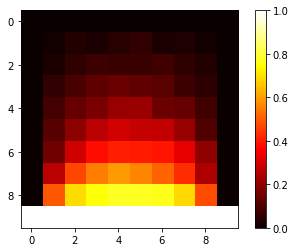

In [111]:
size = 25
iterations = 1000
results = measure_success(iterations, size)
show_success_map(results)

In [115]:
%timeit measure_success(iterations, size)

215 ms ± 5.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Convergence

In this section we study the convergence of the execution time of the algorithm, first as it increases in iteration count, then as it increases in size.

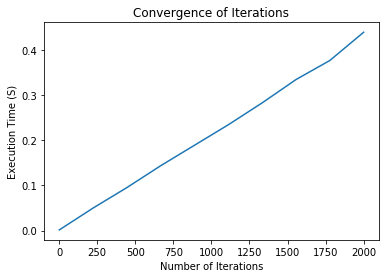

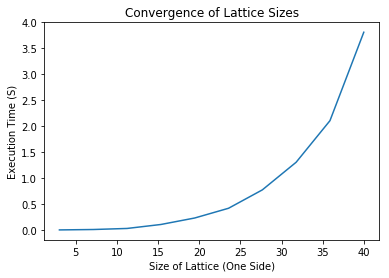

In [143]:
def time_execution(iterations, size, measurements):
    """
    Measure the computing time of the algorithm, averaged over the number
    given by measurments.
    """
    total_time = 0
    for _ in range(measurements):
        timer = -time.process_time()
        measure_success(iterations, size)
        timer += time.process_time()
        total_time += timer
    return total_time/measurements


def measure_exec_convergence_iterations(start, stop, points, repeats, size):
    """
    Measure the execution time of the algorithm for various values
    of iterations.
    """
    iters = np.linspace(start, stop, points)
    exec_times = np.empty_like(iters)
    for i, iteration_count in enumerate(iters):
        exec_times[i] = time_execution(iteration_count, size, repeats)
    return iters, exec_times


def measure_exec_convergence_size(start, stop, points, repeats, iterations):
    """
    Measure the execution time of the algorithm for various values
    of lattice size.
    """
    sizes = np.linspace(start, stop, points)
    exec_times = np.empty_like(sizes)
    for i, size in enumerate(sizes):
        exec_times[i] = time_execution(iterations, size, repeats)
    return sizes, exec_times

#################### Results from Measurements #########################
iteration_counts = np.array([1.00000000e+00,
                             2.23111111e+02,
                             4.45222222e+02,
                             6.67333333e+02,
                             8.89444444e+02,
                             1.11155556e+03,
                             1.33366667e+03,
                             1.55577778e+03,
                             1.77788889e+03,
                             2.00000000e+03])

execution_times_iters = np.array([0.0015625,
                                  0.05     ,
                                  0.0953125,
                                  0.14375  ,
                                  0.1890625,
                                  0.234375 ,
                                  0.2828125,
                                  0.334375 ,
                                  0.3765625,
                                  0.4390625])

sizes_count = np.array([ 3.        ,
                        7.11111111 ,
                        11.22222222,
                        15.33333333,
                        19.44444444,
                        23.55555556,
                        27.66666667,
                        31.77777778,
                        35.88888889,
                        40.        ])

execution_times_sizes = np.array([0.       ,
                                  0.0078125,
                                  0.028125 ,
                                  0.1046875,
                                  0.2296875,
                                  0.4171875,
                                  0.771875 ,
                                  1.3046875,
                                  2.10625  ,
                                  3.8109375])
#######################################################################

# To Repeat Measurments Uncomment the following two lines:

# iteration_counts, execution_times_iters =  measure_exec_convergence_iterations(1, 2000, 10, 10, 10)
# sizes_count, execution_times_sizes = measure_exec_convergence_size(3, 40, 10, 10, 100)

plt.plot(iteration_counts, execution_times_iters)
plt.xlabel('Number of Iterations')
plt.ylabel('Execution Time (S)')
plt.title('Convergence of Iterations')
plt.show()

plt.plot(sizes_count, execution_times_sizes)
plt.xlabel('Size of Lattice (One Side)')
plt.ylabel('Execution Time (S)')
plt.title('Convergence of Lattice Sizes')
plt.show()

#### Analysis of Convergence Results
The plots above illustrate the convergence behviour of the algorithm. According to these measurments, the execution time appears to evolve linearly as the number of iterations increase. Meanwhile the execution time increases exponentially with the increase in lattice size. This is most likely because the number of points that need to be measured inceases quadratically for every increase in the side length.

## Question 2: Potentials Generated by Random Particles

Objectives:
* Implement an efficient method to compute and visualise f(r) for 1 < r < 10
* Estimate the expected relative error (via random placemtns of particles
* Describe your code implementation strategy, optimisations, and the influence of the parameters N, M and number of random trials

### Performance-Optimised Code
Implementation of the problem without parallelisation

In [139]:
@njit
def get_measurement_point(m, R, M, radius):
    """
    """
    angle = m/M*2*np.pi
    x1 = radius*np.cos(angle)
    x2 = radius*np.sin(angle)
    return np.array([x1, x2])

@njit
def get_rm_index(i, R):
    """
    """
    r = i%R
    m = i//R
    return np.array([r, m])


@njit(['float64(float64[:], float64[:,:])'])
def numba_potential(x, y):
    """
    """
    distances = np.sqrt((x[0] - y[:, 0])**2 + (x[1] - y[:, 1])**2)
    potentials = 1/(2*np.pi)*np.log(distances)
    potential = np.sum(potentials)
    return potential


@njit(['float64[:,:](int64)'])
def numba_spawn_y(N):
    """
    Creates N random 2-D points in a unit circle,
    unifromly distributed. [See Reference 1]
    """
    N = int(N)
    relative_points = np.random.rand(N, 2)
    relative_points[:, 1] = np.sqrt(relative_points[:, 1])
    relative_points[:, 0] = relative_points[:, 0]*2*np.pi
    return numba_radial_to_cartesian(relative_points)


@njit(['float64[:](float64[:], int64, int64, int64)'], parallel=True)
def calculate_potentials_along_radii(radii, R, M, N):
    """
    """
    y = numba_spawn_y(N)
    potentials = np.zeros((M, R))
    L = R*M
    for j in prange(L):
        coords = get_rm_index(j, R)
        x = get_measurement_point(coords[1], R, M, radii[coords[0]])
        potentials[coords[1], coords[0]] = numba_potential(x, y)/N
    potentials_per_radius = np.sum(potentials, axis=0)/M
    return potentials_per_radius
    


@njit(['float64[:](float64, float64, int64, int64, int64, int64)'])
def fast_calculate_multi_radii(low, high, R, M, N, iterations):
    """
    Calculate the average potential for N points evenly
    spaced in the range (low, high) - non inclusive """
    results = np.zeros((R, ))
    radii = np.linspace(low, high, R)
    for _ in range(iterations):
        potentials_per_radius = calculate_potentials_along_radii(radii, R, M, N)
        results += potentials_per_radius
    return results/iterations


def show_particles(y):
    """
    Show a scatter plot of the points y.
    """
    plt.scatter(y[:, 0], y[:, 1])
    plt.show()


def single_centre_potential(radius):
    """
    Calculate the uniform potential of a particle at the centre
    of a circle of the given radius on a point on the
    circumfrence.
    """
    return np.log(radius)/(2*np.pi)


def relative_error(centre_point_values, aggregate_values):
    """
    Calculate the relative error for each set of points
    """
    difference = np.linalg.norm(
        centre_point_values - aggregate_values, axis=0
    )
    return np.divide(difference, centre_point_values)

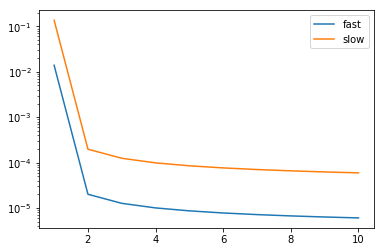

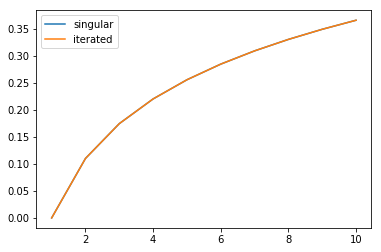

In [140]:
N = 1000
low = 1.001
high = 10
R = 10
M = 10
iterations = 100

y = spawn_y(N)
exact = single_centre_multi_radii(low, high, R)
exper = fast_calculate_multi_radii(low, high, R, M, N, 100)
Ef = relative_error(exact, exper.reshape(R, 1))
r = r_linspace(low, high, R)
plt.semilogy(r, Ef, label='fast')
plt.semilogy(r, E_slow, label='slow')
plt.legend()
plt.show()
plt.plot(r, exact, label='singular')
plt.plot(r, exper, label='iterated')
plt.legend()
plt.show()

In [69]:
%timeit fast_calculate_multi_radii(low, high, R, M, N, iterations)

53.6 ms ± 420 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit fast_calculate_multi_radii(low, high, R, M, N, iterations)

In [ ]:
r_i = np.arange(R)
radius = r_i*(high-low)/R + low
radius

In [ ]:
r_linspace(low, high, R)

# References

[1] https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly/50746409#50746409
